# Assignment 3.2 - Convolutional Neuron Nets (CNNs) in PyTorch

We'will do this in Google Colab - https://colab.research.google.com/
Google Colab allows to run code of the notebook in Google cloud where we can use free GPU!

The authours of the course thanks Google.

Google Colab tutorial is here:
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d
(Do not install Keras the notebook installs PyTorch)

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!ls "/content/drive/My Drive/DeepLearning/data"


test_32x32.mat	train_32x32.mat


In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [5]:
device = torch.device("cuda:0") # Let's make sure GPU is available!
device

device(type='cuda', index=0)

# Load data

In [6]:
# First, lets load the dataset
data_train= dset.SVHN('/content/drive/My Drive/DeepLearning/data/', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('/content/drive/My Drive/DeepLearning/data/', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))
print(len(data_train))

73257


Separate data into training and validation.

Further read - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [7]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)


In [8]:
# We'll use a special helper module to shape it into a flat tensor
# Returns a new tensor with the same data as the self tensor but of a different shape.
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

We'll create simple net with new layers:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [9]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Copy function `compute_accuracy` from previous assignment.  
The only difference - it should first move data to GPU. Do it the same way as in `train_model`

In [10]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None, anneal_epochs=1):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        if scheduler is not None:
              scheduler.step()
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    correct_samples = 0
    total_samples = 0
    
    for (x,y) in loader:
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = model(x_gpu)    
        indices = prediction.argmax(dim = 1)
        correct_samples += indices.eq(y_gpu).sum()
        total_samples += y.shape[0]
    
    return float(correct_samples) / total_samples


In [11]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.346040, Train accuracy: 0.552350, Val accuracy: 0.710532
Average loss: 0.680829, Train accuracy: 0.795175, Val accuracy: 0.809706
Average loss: 0.583823, Train accuracy: 0.825564, Val accuracy: 0.829022
Average loss: 0.533124, Train accuracy: 0.840870, Val accuracy: 0.834551
Average loss: 0.497262, Train accuracy: 0.853240, Val accuracy: 0.843833


# Data augmentation
One of the important methodes while working with images is data augmentation - i.e., generation of the additional training data on the basis of initial data.
So we have an opportunity to increase training data, thus improving the performance of Neural Net. It is important that augmented data resemble the real.
PyTorch has few of such algorithms, so called `transforms`. More here - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms
We will use the following methods of data augmentation:
- ColorJitter - random change of colour
- RandomHorizontalFlip - horisontal flip with probabiity of 50%
- RandomVerticalFlip - vertical flip with probabiity of  50%
- RandomRotation - random rotation 

In [12]:
!ls "/content/drive/My Drive/DeepLearning/data"


test_32x32.mat	train_32x32.mat


In [13]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('/content/drive/My Drive/DeepLearning/data', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)
print(len(data_aug_train))

73257


Visualize augmentation results (in general, it's very useful to llok at generated data).

Length of augmented data 73257


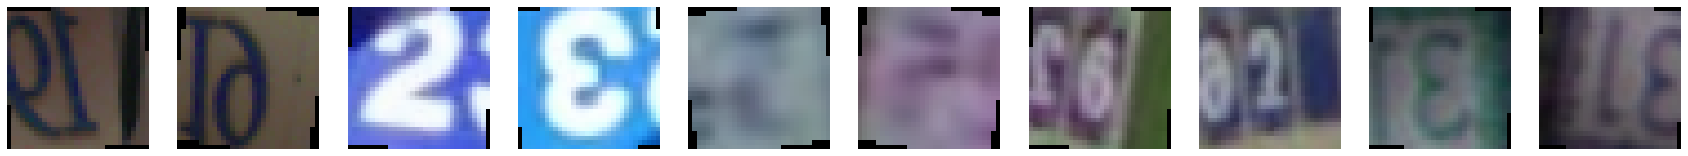

In [14]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('/content/drive/My Drive/DeepLearning/data', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))
print("Length of augmented data",len(data_aug_vis))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Are all of them useful in this set of data? Could some of them be unhelpful? 

Choose only the correct ones 

Length of augmented data 73257


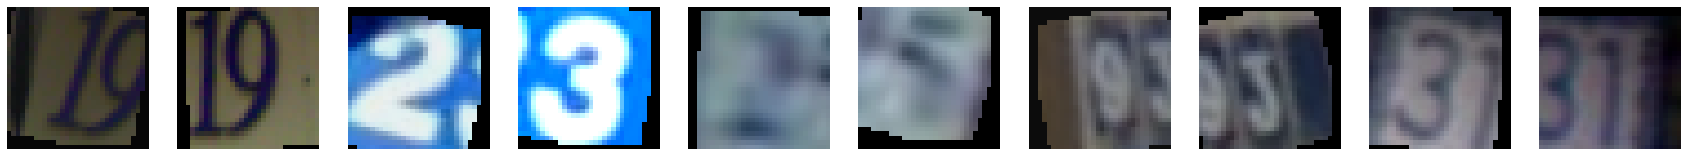

In [32]:
tfs = transforms.Compose([ 
    transforms.RandomRotation(18, resample=PIL.Image.BILINEAR),                        
    transforms.Pad(padding=2),
    transforms.RandomCrop(size=(32, 32)),
    transforms.ColorJitter(
            brightness=63.0 / 255.0, saturation=[0.5, 1.5], contrast=[0.2, 1.8]
        ),

])

data_aug_vis = dset.SVHN('/content/drive/My Drive/DeepLearning/data', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))
print("Length of augmented data",len(data_aug_vis))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

In [16]:
# TODO: 
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.RandomRotation(18, resample=PIL.Image.BILINEAR),
    transforms.Pad(padding=2),
    transforms.RandomCrop(size=(32, 32)),
    transforms.ColorJitter(
            brightness=63.0 / 255.0, saturation=[0.5, 1.5], contrast=[0.2, 1.8]
        ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])           
                   
])


In [17]:
# Finally, let's train with augmentations!
increased_dataset = torch.utils.data.ConcatDataset([data_aug_train,data_train])
print(len(increased_dataset))

train_aug_loader = torch.utils.data.DataLoader(increased_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

146514
Average loss: 2.015332, Train accuracy: 0.286404, Val accuracy: 0.495393
Average loss: 1.773288, Train accuracy: 0.363802, Val accuracy: 0.494301
Average loss: 1.654063, Train accuracy: 0.408934, Val accuracy: 0.467477
Average loss: 1.584867, Train accuracy: 0.435450, Val accuracy: 0.487953
Average loss: 1.529485, Train accuracy: 0.456370, Val accuracy: 0.459696


# LeNet
Let's implement classical architecture of convolutional neural net, suggested by 1998. At the time it acheved impressive result on  MNIST, let's see how it'l deal with SVHN?
It is described in ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), try to read key parts and implement suggestes architecture with PyTorch.

Do not implement layers and loss function LeNet, that is not present in PyTorch, - simply take their dimensions and transform them into в Convolutional, Pooling и Fully Connected layers.

If you don't understand the paper, google LeNet to get the details :)

In [18]:
# TODO: Implement LeNet-like architecture for SVHN task
# C1-S2-C3-S4-C5-F6
# C_x convolutional layer
# S_x subsampling, pooling layer
# F_x - fully-connected layer
# x - index of layer, output size for convolutional layer (W-F+2P)/S+1
# Layer 1 C1 input(32x32x3) 6 kernels size of 5x5, output (28x28x6)
# Tanh
# Layer 2 S2 2x2, stride 2, 6 kernels output (28/2,28/2,6)
# Layer 3 C3 input(14x14x6) 6 kernels size of 5x5, stride 1, output (10x10x16)
# Layer 4 S4 input(10x10x16) output (5x5x16)
# Layer 5 C5 input(5x5x16) 120 kernels size of 5x5 kernels output (1x1x120)
# Layer 6 F6 input(120) output (84)
# Layer 7 F7 input(84) output (10)
torch.manual_seed(50)
lenet_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2), 
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1), 
            nn.Tanh(),
            Flattener(),
            nn.Linear(in_features=120, out_features=84),  
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [19]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_loader, val_loader, loss, optimizer, 10)

Average loss: 1.152462, Train accuracy: 0.619510, Val accuracy: 0.815303
Average loss: 0.505202, Train accuracy: 0.848446, Val accuracy: 0.842059
Average loss: 0.431737, Train accuracy: 0.870781, Val accuracy: 0.861716
Average loss: 0.389024, Train accuracy: 0.883323, Val accuracy: 0.869838
Average loss: 0.358037, Train accuracy: 0.892690, Val accuracy: 0.876186
Average loss: 0.332100, Train accuracy: 0.898748, Val accuracy: 0.873592
Average loss: 0.311576, Train accuracy: 0.905743, Val accuracy: 0.881851
Average loss: 0.293819, Train accuracy: 0.911511, Val accuracy: 0.878780
Average loss: 0.277222, Train accuracy: 0.917039, Val accuracy: 0.881169
Average loss: 0.259193, Train accuracy: 0.922738, Val accuracy: 0.873865


# Hyper parameters

In [20]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well
from torch.optim.lr_scheduler import StepLR

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e0, 1e-1, 1e-2, 1e-3, 1e-4]
anneal_coeff = 0.2
anneal_epochs = [1, 5, 10, 15, 20, 50]
reg = [1e-3, 1e-4, 1e-5, 1e-7]

#lr, aep, reg =hparams
param_grid = np.array(np.meshgrid(learning_rates, anneal_epochs, reg)).T.reshape(-1,3)


batch_size = 64
epoch_num = 10

run_record = {} 
for item in param_grid:
  lr = item[0]
  anneal_epchs = item[1]
  reg = item[2]
  hparams = Hyperparams(lr,anneal_epchs,reg)

  optimizer = optim.SGD(lenet_model.parameters(), lr=lr, weight_decay=reg)
  scheduler = StepLR(optimizer, step_size=anneal_epchs, gamma=anneal_coeff)
  
  # Record all the runs here
  # Key should be Hyperparams and values should be RunResult
  print("lr",lr,"anneal_epchs",anneal_epchs,"reg",reg)
  loss_history, train_history, val_history
  loss_history, train_history, val_history = train_model(lenet_model, train_loader, val_loader, loss, optimizer, epoch_num, scheduler, anneal_epchs)
  run_res = RunResult(lenet_model, train_history, val_history, val_history[-1])
  run_record[hparams] = run_res


lr 1.0 anneal_epchs 1.0 reg 0.001
Average loss: 3.446593, Train accuracy: 0.282940, Val accuracy: 0.514641
Average loss: 0.907914, Train accuracy: 0.716121, Val accuracy: 0.761859
Average loss: 0.630461, Train accuracy: 0.805702, Val accuracy: 0.797283
Average loss: 0.569572, Train accuracy: 0.825359, Val accuracy: 0.799877
Average loss: 0.556814, Train accuracy: 0.829932, Val accuracy: 0.800150
Average loss: 0.554081, Train accuracy: 0.830751, Val accuracy: 0.799672
Average loss: 0.553622, Train accuracy: 0.831041, Val accuracy: 0.799672
Average loss: 0.553551, Train accuracy: 0.831041, Val accuracy: 0.799672
Average loss: 0.553452, Train accuracy: 0.831075, Val accuracy: 0.799672
Average loss: 0.553422, Train accuracy: 0.831075, Val accuracy: 0.799672
train_history 0.5534223318099976 val_history 0.8310753165204928 final_val_accuracy 0.7996723773121288
lr 1.0 anneal_epchs 5.0 reg 0.001
Average loss: 1.099402, Train accuracy: 0.673242, Val accuracy: 0.675722
Average loss: 0.905102, Tra

In [26]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

Best validation accuracy: 0.90, best hyperparams: Hyperparams(learning_rate=0.01, anneal_epochs=5.0, reg=0.001)


# Free exercise - catch up to and take over LeNet!

Try to find the architecture and the training parameters, to improve on previous models.

What could be tried:
- BatchNormalization (for convolution layers in PyTorch it is called [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Change number of layers and their thickness
- Change number of training epochs
- try different augmentations

In [29]:
torch.manual_seed(50)
lenet_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            # normalize
            nn.BatchNorm2d(6),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            # normalize
            nn.BatchNorm2d(16), 
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1), 
            nn.Tanh(),
            nn.Flatten(start_dim=1),
            # normalize
            nn.BatchNorm1d(120),
            nn.Linear(in_features=120, out_features=84),  
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)

In [30]:
learning_rate=0.01
anneal_epochs=5.0
reg=0.001

optimizer = optim.SGD(lenet_model.parameters(), lr=learning_rate, weight_decay=reg)
scheduler = StepLR(optimizer, step_size=anneal_epochs, gamma=anneal_coeff)
  
  # Record all the runs here
  # Key should be Hyperparams and values should be RunResult
loss_history, train_history, val_history = train_model(lenet_model, train_loader, val_loader, loss, optimizer, epoch_num, scheduler, anneal_epchs)

print("Best validation accuracy: %4.2f",val_history[-1])
best_model = None

Average loss: 1.536138, Train accuracy: 0.495990, Val accuracy: 0.739130
Average loss: 0.726707, Train accuracy: 0.787223, Val accuracy: 0.824312
Average loss: 0.563008, Train accuracy: 0.833498, Val accuracy: 0.846086
Average loss: 0.495561, Train accuracy: 0.853616, Val accuracy: 0.856665
Average loss: 0.453257, Train accuracy: 0.866447, Val accuracy: 0.858508
Average loss: 0.411929, Train accuracy: 0.879808, Val accuracy: 0.871818
Average loss: 0.405757, Train accuracy: 0.881821, Val accuracy: 0.872364
Average loss: 0.401792, Train accuracy: 0.882572, Val accuracy: 0.874275
Average loss: 0.395672, Train accuracy: 0.884653, Val accuracy: 0.875299
Average loss: 0.390557, Train accuracy: 0.885677, Val accuracy: 0.875299
Best validation accuracy: %4.2f 0.8752986144290492
